In [1]:
# Install dependencies
!pip install pandas scikit-learn nltk torch transformers kaggle


In [2]:
from google.colab import files
files.upload()   # 👉 Select kaggle.json from your computer


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moseskirubagar","key":"27f1e383e829f3a816dcbd88f68a2317"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!ls ~/.kaggle



kaggle.json


In [5]:
!kaggle datasets list -s "amazon customer reviews"


ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
cynthiarempel/amazon-us-customer-reviews-dataset                Amazon US Customer Reviews Dataset                  22497731749  2021-06-16 20:07:46.343000          20905        101  1.0              
bhavikardeshna/amazon-customerreviews-polarity                  Amazon Customer-Reviews Polarity                      700672680  2022-06-27 19:10:45.673000           1521         20  0.7941176        
karkavelrajaj/amazon-sales-dataset                              Amazon Sales Dataset                                    2043633  2023-01-17 06:21:15.450000         236520       1378  1.0          

In [6]:
# Download smaller dataset (~4 MB)
!kaggle datasets download -d thedevastator/amazon-customer-reviews-with-2013-2019-sentiment -p ./data

# Unzip it
!unzip ./data/amazon-customer-reviews-with-2013-2019-sentiment.zip -d ./data


Dataset URL: https://www.kaggle.com/datasets/thedevastator/amazon-customer-reviews-with-2013-2019-sentiment
License(s): CC0-1.0
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 1.10GB/s]
Archive:  ./data/amazon-customer-reviews-with-2013-2019-sentiment.zip
  inflating: ./data/Amazon Review Data Web Scrapping - Amazon Review Data Web Scrapping.csv  


In [7]:
import pandas as pd

# Load dataset
df = pd.read_csv("./data/Amazon Review Data Web Scrapping - Amazon Review Data Web Scrapping.csv")

# Check shape and first rows
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (60889, 6)


,Unique_ID,Category,Review_Header,Review_text,Rating,Own_Rating
0,136040,smartTv,Nice one,I liked it,5,Positive
1,134236,mobile,Huge battery life with amazing display,I bought the phone on Amazon and been using my...,5,Positive
2,113945,books,Four Stars,"Awesome book at reasonable price, must buy ......",4,Positive
3,168076,smartTv,Nice quality,good,5,Positive
4,157302,books,Nice book,"The book is fine,not bad,contains nice concept...",3,Neutral


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

def clean_text(text):
    text = re.sub(r"<.*?>", "", str(text))   # remove HTML
    text = re.sub(r"[^a-zA-Z]", " ", str(text))  # keep only letters
    text = text.lower()
    tokens = text.split()
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

# Apply cleaning
df["cleaned_review"] = df["Review_text"].apply(clean_text)

# Select only needed columns
df_final = df[["cleaned_review", "Own_Rating"]].rename(columns={"Own_Rating": "sentiment"})

# Check distribution of labels
print(df_final["sentiment"].value_counts())

df_final.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


sentiment
Positive    47436
Negative     9087
Neutral      4366
Name: count, dtype: int64


,cleaned_review,sentiment
0,liked,Positive
1,bought phone amazon using samsung couple week ...,Positive
2,awesome book reasonable price must buy,Positive
3,good,Positive
4,book fine bad contains nice concept nicely exp...,Neutral


In [9]:
from sklearn.model_selection import train_test_split

X = df_final["cleaned_review"]
y = df_final["sentiment"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))


Train size: 42622
Validation size: 9133
Test size: 9134


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Convert text → TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)

# Evaluate on validation set
y_pred = model_lr.predict(X_valid_tfidf)
print("Validation Performance:\n", classification_report(y_valid, y_pred))


Validation Performance:
               precision    recall  f1-score   support

    Negative       0.75      0.66      0.70      1363
     Neutral       0.30      0.03      0.05       655
    Positive       0.88      0.97      0.92      7115

    accuracy                           0.86      9133
   macro avg       0.64      0.55      0.56      9133
weighted avg       0.82      0.86      0.83      9133



In [11]:
y_test_pred = model_lr.predict(X_test_tfidf)
print("Test Performance:\n", classification_report(y_test, y_test_pred))


Test Performance:
               precision    recall  f1-score   support

    Negative       0.75      0.69      0.72      1363
     Neutral       0.36      0.03      0.06       655
    Positive       0.89      0.98      0.93      7116

    accuracy                           0.87      9134
   macro avg       0.67      0.57      0.57      9134
weighted avg       0.83      0.87      0.84      9134



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_valid_tfidf)
print("Random Forest Validation Performance:\n", classification_report(y_valid, rf_pred))

# SVM
svm_model = LinearSVC(class_weight="balanced", random_state=42)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_valid_tfidf)
print("SVM Validation Performance:\n", classification_report(y_valid, svm_pred))


Random Forest Validation Performance:
               precision    recall  f1-score   support

    Negative       0.73      0.61      0.66      1363
     Neutral       0.22      0.06      0.09       655
    Positive       0.87      0.96      0.91      7115

    accuracy                           0.84      9133
   macro avg       0.60      0.54      0.56      9133
weighted avg       0.80      0.84      0.82      9133

SVM Validation Performance:
               precision    recall  f1-score   support

    Negative       0.66      0.70      0.68      1363
     Neutral       0.22      0.24      0.23       655
    Positive       0.92      0.90      0.91      7115

    accuracy                           0.82      9133
   macro avg       0.60      0.61      0.61      9133
weighted avg       0.83      0.82      0.83      9133



In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_valid_seq = pad_sequences(tokenizer.texts_to_sequences(X_valid), maxlen=100)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# Build LSTM model
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(len(le.classes_), activation="softmax")
])

model_lstm.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train
history = model_lstm.fit(X_train_seq, y_train_enc,
                         validation_data=(X_valid_seq, y_valid_enc),
                         epochs=3, batch_size=64)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
666/666 ━━━━━━━━━━━━━━━━━━━━ 220s 317ms/step - accuracy: 0.8157 - loss: 0.5671 - val_accuracy: 0.8617 - val_loss: 0.4072
Epoch 2/3
666/666 ━━━━━━━━━━━━━━━━━━━━ 260s 321ms/step - accuracy: 0.8689 - loss: 0.3942 - val_accuracy: 0.8615 - val_loss: 0.3968
Epoch 3/3
666/666 ━━━━━━━━━━━━━━━━━━━━ 213s 320ms/step - accuracy: 0.8792 - loss: 0.3558 - val_accuracy: 0.8584 - val_loss: 0.4181


286/286 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step
LSTM Test Performance:
               precision    recall  f1-score   support

    Negative       0.73      0.69      0.71      1363
     Neutral       0.25      0.03      0.05       655
    Positive       0.89      0.97      0.93      7116

    accuracy                           0.86      9134
   macro avg       0.62      0.56      0.56      9134
weighted avg       0.82      0.86      0.83      9134



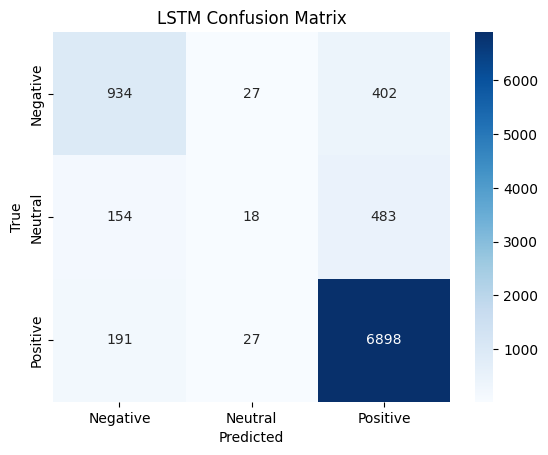

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_test_pred_probs = model_lstm.predict(X_test_seq)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Map back to labels
y_test_labels = le.inverse_transform(y_test_enc)
y_pred_labels = le.inverse_transform(y_test_pred)

# Classification report
print("LSTM Test Performance:\n", classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM Confusion Matrix")
plt.show()


In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [17]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
import os

# Disable W&B logging
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

# Sample 10k for Colab speed
df_small = df_final.sample(10000, random_state=42)
df_small["label"] = df_small["sentiment"].map({"Negative":0, "Neutral":1, "Positive":2})

# Tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["cleaned_review"], padding="max_length", truncation=True, max_length=128)

dataset = HFDataset.from_pandas(df_small).map(tokenize, batched=True)
train_test = dataset.train_test_split(test_size=0.2, seed=42)

# Model
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    report_to="none"   # disables W&B
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_test["train"],
    eval_dataset=train_test["test"],

)

trainer.train()


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Epoch,Training Loss,Validation Loss
1,0.431091,0.403416
2,0.288617,0.408708


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=1000, training_loss=0.42579414176940916, metrics={'train_runtime': 379.0167, 'train_samples_per_second': 42.214, 'train_steps_per_second': 2.638, 'total_flos': 1052453670912000.0, 'train_loss': 0.42579414176940916, 'epoch': 2.0})

BERT Test Performance:
               precision    recall  f1-score   support

    Negative       0.70      0.73      0.71       298
     Neutral       0.13      0.02      0.04       140
    Positive       0.90      0.96      0.93      1562

    accuracy                           0.86      2000
   macro avg       0.58      0.57      0.56      2000
weighted avg       0.82      0.86      0.83      2000



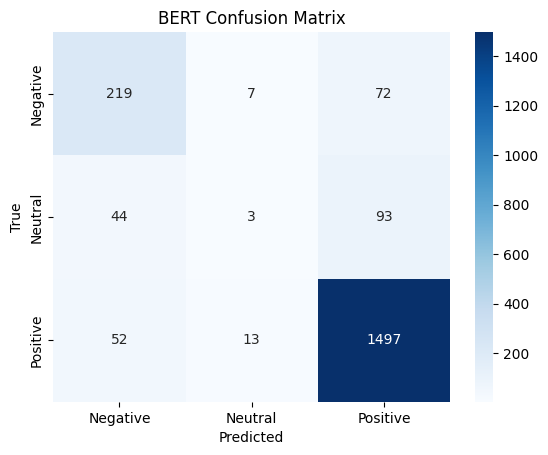

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
preds = trainer.predict(train_test["test"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

# Classification report
print("BERT Test Performance:\n", classification_report(
    y_true, y_pred, target_names=["Negative", "Neutral", "Positive"])
)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix")
plt.show()
